## Imports

In [ ]:
from typing import List


%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import requests
import pandas_profiling as pp
import os
import graphviz
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
# from pandas_profiling.utils.cache import cache_file

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

Populating the interactive namespace from numpy and matplotlib


---
# Load Data

## Constants

We define some constants used in the whole notebook

In [ ]:
DATA_PATH = "https://raw.githubusercontent.com/Citoci/SpaceshipTitanic/master/data/"
OUTPUT_PATH = "/content/"
RANDOM_STATE = 3993

## Dataset

We load the dataset and the target (that will be used to train the models)

In [ ]:
dataset = pd.read_csv(DATA_PATH + "train.csv")

# Save the target column and drop the target
target = dataset.Transported
dataset.drop(columns="Transported", inplace=True)

# Set the index
dataset.set_index('PassengerId', inplace=True)

# Sort columns by name
dataset.sort_index(axis="columns", inplace=True)

original_dataset = dataset.copy()

dataset

,Age,Cabin,CryoSleep,Destination,FoodCourt,HomePlanet,Name,RoomService,ShoppingMall,Spa,VIP,VRDeck
PassengerId,,,,,,,,,,,,
0001_01,39.0,B/0/P,False,TRAPPIST-1e,0.0,Europa,Maham Ofracculy,0.0,0.0,0.0,False,0.0
0002_01,24.0,F/0/S,False,TRAPPIST-1e,9.0,Earth,Juanna Vines,109.0,25.0,549.0,False,44.0
0003_01,58.0,A/0/S,False,TRAPPIST-1e,3576.0,Europa,Altark Susent,43.0,0.0,6715.0,True,49.0
0003_02,33.0,A/0/S,False,TRAPPIST-1e,1283.0,Europa,Solam Susent,0.0,371.0,3329.0,False,193.0
0004_01,16.0,F/1/S,False,TRAPPIST-1e,70.0,Earth,Willy Santantines,303.0,151.0,565.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,41.0,A/98/P,False,55 Cancri e,6819.0,Europa,Gravior Noxnuther,0.0,0.0,1643.0,True,74.0
9278_01,18.0,G/1499/S,True,PSO J318.5-22,0.0,Earth,Kurta Mondalley,0.0,0.0,0.0,False,0.0
9279_01,26.0,G/1500/S,False,TRAPPIST-1e,0.0,Earth,Fayey Connon,0.0,1872.0,1.0,False,0.0


---
# Global Data Analysis and Preprocessing

## Helper Transformers

Defining some helper transformers to be used in the pipelines

In [ ]:
# used to sort the columns in a pipeline to avoid transforming problems
columns_sorter = FunctionTransformer(lambda ds: ds.sort_index(axis='columns'))

In [ ]:
def array_to_dataframe(arr: np.ndarray, columns: List[str]):
    return pd.DataFrame(data=arr, columns=columns)

# used to transform an array to a dataset inside a pipeline
def array_to_dataframer(columns=None):
  if columns!=None:
    return FunctionTransformer(lambda ds: array_to_dataframe(ds, columns))
  else:
    return FunctionTransformer(lambda ds: array_to_dataframe(ds, [f"col{i}" for i in range(ds.shape[1])]))

## Missing Values






### Helper functions for missing values

In [ ]:
def count_missing(ds: pd.DataFrame):
    return ds.shape[0] - ds.count()

In [ ]:
def get_sample_with_nans(ds: pd.DataFrame):
    return ds.loc[ds.isna().any(axis=1)]

In [ ]:
sample_with_nans_ids = get_sample_with_nans(dataset).index

### Impute Missing Values

Global imputers to be used on the whole dataset before any method

In [ ]:
nominal_imputer = SimpleImputer(strategy="most_frequent")
numeric_imputer = KNNImputer()


NOMINAL_IMPUTER_COLS = ["Cabin", "CryoSleep", "Destination", "HomePlanet", "Name", "VIP"]
NUMERIC_IMPUTER_COLS = ["Age", "FoodCourt", "RoomService", "ShoppingMall", "Spa", "VRDeck"]

# Create the imputer of mixed type columns
imputer = ColumnTransformer(
    transformers=[
        ("impute_numeric", numeric_imputer, NUMERIC_IMPUTER_COLS),
        ("impute_nominal", nominal_imputer, NOMINAL_IMPUTER_COLS),
    ],
    verbose=True,
)

imputer.fit(dataset)

imputer = Pipeline(
    steps=[
           ("imputer", imputer),
           ("columns", array_to_dataframer(NUMERIC_IMPUTER_COLS+NOMINAL_IMPUTER_COLS)),
           ("sorter", columns_sorter)
    ]
)

[ColumnTransformer]  (1 of 2) Processing impute_numeric, total=   1.2s
[ColumnTransformer]  (2 of 2) Processing impute_nominal, total=   0.0s


## Feature Construction

The `Cabin` variable is composed of 3 sub-strings: we can subdivide it in 3 different variables

In [ ]:
def cabin_split_function(ds):
  splitted_cabin = ds['Cabin'].transform(lambda x: x.split('/'))
  ds[["CabinLetter", 'CabinNumber', 'CabinPS']] = pd.DataFrame(item for item in splitted_cabin).set_index(ds.index)
  return ds.drop(columns=['Cabin'])

cabin_transformer = Pipeline(
    steps=[
           ("cabin", FunctionTransformer(cabin_split_function)),
           ("sorter", columns_sorter),
    ]
)

## Feature Dropping

In [ ]:
def column_dropper(columns):
  return FunctionTransformer(lambda ds: ds.drop(columns=columns))

## Final Global Preprocessor

In [ ]:
global_preprocessor = Pipeline(
    steps=[
           ("imputer", imputer),
           ("cabin", cabin_transformer),
           ("dropper", column_dropper(["Name"]))
    ]
)

pp_dataset = global_preprocessor.transform(dataset)
pp_dataset

,Age,CabinLetter,CabinNumber,CabinPS,CryoSleep,Destination,FoodCourt,HomePlanet,RoomService,ShoppingMall,Spa,VIP,VRDeck
0,39.0,B,0,P,False,TRAPPIST-1e,0.0,Europa,0.0,0.0,0.0,False,0.0
1,24.0,F,0,S,False,TRAPPIST-1e,9.0,Earth,109.0,25.0,549.0,False,44.0
2,58.0,A,0,S,False,TRAPPIST-1e,3576.0,Europa,43.0,0.0,6715.0,True,49.0
3,33.0,A,0,S,False,TRAPPIST-1e,1283.0,Europa,0.0,371.0,3329.0,False,193.0
4,16.0,F,1,S,False,TRAPPIST-1e,70.0,Earth,303.0,151.0,565.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,A,98,P,False,55 Cancri e,6819.0,Europa,0.0,0.0,1643.0,True,74.0
8689,18.0,G,1499,S,True,PSO J318.5-22,0.0,Earth,0.0,0.0,0.0,False,0.0
8690,26.0,G,1500,S,False,TRAPPIST-1e,0.0,Earth,0.0,1872.0,1.0,False,0.0
8691,32.0,E,608,S,False,55 Cancri e,1049.0,Europa,0.0,0.0,353.0,False,3235.0


## Feature subdivision (binary, nominal, numerical)

In [ ]:
# Count the number of unique values in dataframe
cols_unique_vals_count = pp_dataset.nunique().sort_values()
cols_unique_vals_count

CabinPS            2
CryoSleep          2
VIP                2
Destination        3
HomePlanet         3
CabinLetter        8
Age              131
ShoppingMall    1180
RoomService     1344
VRDeck          1365
Spa             1396
FoodCourt       1566
CabinNumber     1817
dtype: int64

In [ ]:
# If the column has only 2 unique values it is a binary col
BINARY_COLS = [col for col, val in cols_unique_vals_count.items() if val == 2]
BINARY_COLS

['CabinPS', 'CryoSleep', 'VIP']

In [ ]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NOMINAL_NUNIQUE_THRESHOLD = 10
NOMINAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > 2 and val < NOMINAL_NUNIQUE_THRESHOLD
]
NOMINAL_COLS

['Destination', 'HomePlanet', 'CabinLetter']

In [ ]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NUMERICAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > NOMINAL_NUNIQUE_THRESHOLD
]
NUMERICAL_COLS

['Age',
 'ShoppingMall',
 'RoomService',
 'VRDeck',
 'Spa',
 'FoodCourt',
 'CabinNumber']

In [ ]:
# Create the categorical columns list as binary + nominal
CATEGORICAL_COLS = BINARY_COLS + NOMINAL_COLS
CATEGORICAL_COLS

['CabinPS', 'CryoSleep', 'VIP', 'Destination', 'HomePlanet', 'CabinLetter']

---
# Kaggle



In [ ]:
def generateSubmission(model, model_preprocessor, model_postprocessor=None, file_name = "last_submission.csv", description="", direct_submit_to_kaggle=False):
  # Read the test data
  test_ds = pd.read_csv(DATA_PATH + "test.csv").set_index('PassengerId').sort_index(axis='columns')
  # print(test_ds.info())

  # Applying global preprocessing identical to train data
  pp_test = global_preprocessor.transform(test_ds)

  pp_test = model_preprocessor.transform(pp_test)
  # print(pp_test.info())

  # Use the model to make predictions
  y_test_pred = np.squeeze(model.predict(pp_test))
  # print(y_test_pred)

  if model_postprocessor:
    y_test_pred = model_postprocessor.transform(y_test_pred)

  # submission file
  submission = pd.DataFrame({"PassengerId": test_ds.index, "transported": y_test_pred})
  print(submission)

  if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

  # you could use any filename. We choose submission here
  submission.to_csv(OUTPUT_PATH + file_name, index=False)

  # Submit authomatically; kaggle API authentication needed
  if (direct_submit_to_kaggle):
    print("Pushin submission to Kaggle...")
    from google.colab import drive
    drive.mount('/content/gdrive')
    !mkdir -p ~/.kaggle
    !cp "/content/gdrive/My Drive/kaggle.json" ~/.kaggle/
    !pip install kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle competitions submit -c spaceship-titanic -f {OUTPUT_PATH + file_name} -m description


---
# Decision Trees

## Preprocessing

In [ ]:
dt_dataset = pp_dataset.copy()

### Column dropping

Whe chose to remove the columns that we saw were never used by this model (they had low/zero feature importance in the sections below)

In [ ]:
DT_DROP_COLUMNS = ['CabinNumber']

dt_column_dropper = column_dropper(DT_DROP_COLUMNS)

### Numerizing features

Decision Trees can split automatically only numerical features: we need a way to transform binary and nominal features to numerical ones. We chose an Ordinal Encoder to preserve the original feature dimensions and to keep the decision tree simple and readable.

In [ ]:
# Create categorical transformer (binary + nominal)
categorical_transformer = Pipeline(
    steps=[
        #("one_hot_encoder", OneHotEncoder(sparse=False)),
        ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
# Create numeric transformer
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [ ]:
# Create the imputer of mixed type columns
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)


# Column names after mixed imputation procedure
COLUMN_NAMES = NUMERICAL_COLS + CATEGORICAL_COLS

In [ ]:
# Fit the column transformer
numerizer.fit(dt_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer(columns=COLUMN_NAMES))
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.0s


In [ ]:
dt_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", dt_column_dropper),
          #  ("sorter", columns_sorter)
    ]
)

dt_dataset = dt_preprocessor.transform(dt_dataset)
dt_dataset

,Age,ShoppingMall,RoomService,VRDeck,Spa,FoodCourt,CabinNumber,CabinPS,CryoSleep,VIP,Destination,HomePlanet,CabinLetter
0,0.705117,-0.287939,-0.338270,-0.265818,-0.273560,-0.283565,-1.191744,-1.032865,-0.732770,-0.153063,0.620545,0.440385,-1.883161
1,-0.338899,-0.246165,-0.173619,-0.227037,0.213965,-0.277930,-1.191744,0.968181,-0.732770,-0.153063,0.620545,-0.817259,0.369299
2,2.027537,-0.287939,-0.273316,-0.222630,5.689517,1.955440,-1.191744,0.968181,-0.732770,6.533255,0.620545,0.440385,-2.446276
3,0.287511,0.331980,-0.338270,-0.095712,2.682670,0.519747,-1.191744,0.968181,-0.732770,-0.153063,0.620545,0.440385,-2.446276
4,-0.895707,-0.035627,0.119428,-0.264055,0.228174,-0.239736,-1.189769,0.968181,-0.732770,-0.153063,0.620545,-0.817259,0.369299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.844319,-0.287939,-0.338270,-0.200596,1.185463,3.985946,-0.998198,-1.032865,-0.732770,6.533255,-1.833685,0.440385,-2.446276
8689,-0.756505,-0.287939,-0.338270,-0.265818,-0.273560,-0.283565,1.768722,0.968181,1.364685,-0.153063,-0.606570,-0.817259,0.932414
8690,-0.199696,2.840060,-0.338270,-0.265818,-0.272672,-0.283565,1.770697,0.968181,-0.732770,-0.153063,0.620545,-0.817259,0.932414
8691,0.217910,-0.287939,-0.338270,2.585435,0.039913,0.373235,0.009032,0.968181,-0.732770,-0.153063,-1.833685,0.440385,-0.193816


## Base Decision Tree Model Training

Let's train a static Decision Tree Classifier, using some random meta-parameters
The score on the training dataset is already good, but could be subject to overfitting.

In [ ]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=3)
dtc.fit(dt_dataset, target)
dtc.score(dt_dataset, target)

0.718279075117911

We print the feature importances: it seems that the CryoSleep feature was the most important in the splits!

In [ ]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    data=dtc.feature_importances_,
    index=dt_dataset.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
feature_importances

,importance
CryoSleep,0.671308
Spa,0.123090
HomePlanet,0.095858
RoomService,0.092268
CabinNumber,0.008850
FoodCourt,0.008627
Age,0.000000
ShoppingMall,0.000000
VRDeck,0.000000
CabinPS,0.000000


Here we try to make a prediction and evaluate the confusion matrix and some other score metrics:


In [ ]:
y_pred = dtc.predict(dt_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3761  554]
 [1895 2483]]
Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.87      0.75      4315
        True       0.82      0.57      0.67      4378

    accuracy                           0.72      8693
   macro avg       0.74      0.72      0.71      8693
weighted avg       0.74      0.72      0.71      8693



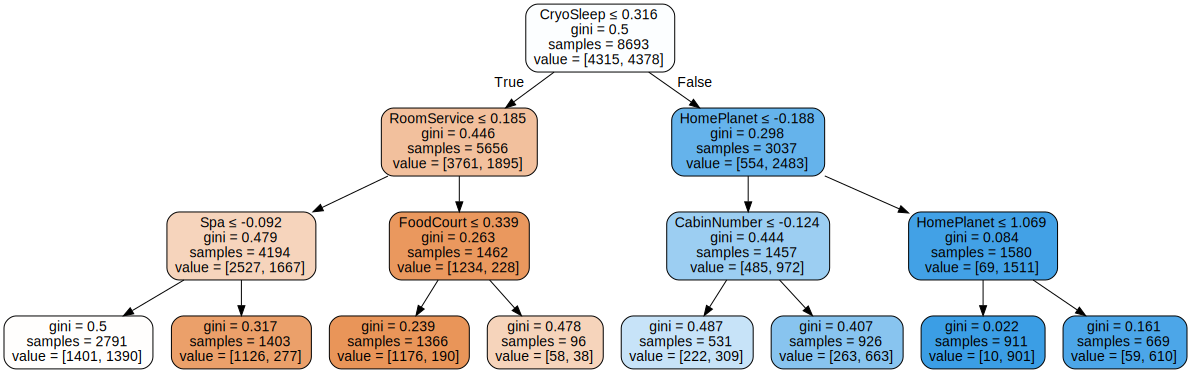

In [ ]:
dot_data = export_graphviz(
    decision_tree=dtc,
    out_file="decision_tree_heart_desease.dot",
    feature_names=dt_dataset.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

# Read the dot graph and display image
with open("decision_tree_heart_desease.dot") as f:
    dot_graph = f.read()

# display(graphviz.Source(dot_graph))
display(graphviz.Source(dot_graph))

### Validation

We can split the dataset into a a train set and a test set
We use the train set to fit the model, and the test set to measure the score

In [ ]:
xtr, xte, ytr, yte = train_test_split(dt_dataset, target)

dtc.fit(xtr, ytr)
dtc.score(xte, yte)

# result is not so distant from before -> good thing
# in this case is a bit distant... we have a little overfitting

0.7175712971481141

The score is not really far from the one got from the training set, so we could say that there's less chance that the model goes in overfitting

We can also use K-Fold cross validation to have a more affordable validation, let's say with k=10

In [ ]:
cv_scores = cross_val_score(
    dtc, dt_dataset, target, cv=10, scoring="accuracy", verbose=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


Text(0.5, 1.0, 'Average score: 0.7134501276404376')

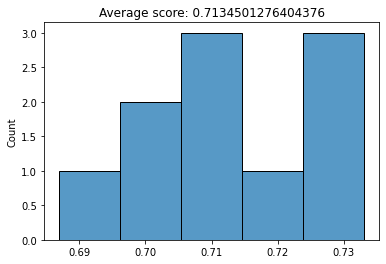

In [ ]:
sns.histplot(cv_scores)
plt.title("Average score: {}".format(np.mean(cv_scores)))

Also here, we see that the average score is really similar to the model fitted with the whole dataset

## Parameter Tuning with Grid Search

Until now, we used a static Decision Tree Classifier with randomly chosen parameters. Let's test different parameters configurations, and see what's the best one in terms of score. We perform a Grid Search over multiple parameters, and test the models using K-Fold cross validation.

In [ ]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
# Create the parameter grids
parameter_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [2, 3, 4, 5, 6, 7, 8],
    "max_features": ["sqrt", "log2", None],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(dt_dataset, target)
# grid_search.cv_results_

Fitting 10 folds for each of 84 candidates, totalling 840 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=3993),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'splitter': ['best', 'random']},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.7700474848881658
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'splitter': 'best'}


DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       random_state=3993)

We can observe that increasing the max_depth is the main changer for the DTC score

In [ ]:
y_pred = best_dtc.predict(dt_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3242 1073]
 [ 742 3636]]
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.75      0.78      4315
        True       0.77      0.83      0.80      4378

    accuracy                           0.79      8693
   macro avg       0.79      0.79      0.79      8693
weighted avg       0.79      0.79      0.79      8693



In [ ]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    best_dtc.feature_importances_, index=dt_dataset.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importances

,importance
Spa,0.286520
VRDeck,0.191886
CabinLetter,0.127049
FoodCourt,0.103039
ShoppingMall,0.090693
RoomService,0.065903
CryoSleep,0.041068
CabinNumber,0.035943
Age,0.029451
CabinPS,0.011030


## Submission

In [ ]:
generateSubmission(
    best_dtc,
    model_preprocessor=dt_preprocessor,
    file_name="tuned_decis_tree.csv", 
    direct_submit_to_kaggle=False
)

     PassengerId  transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01        False
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01         True
4274     9271_01         True
4275     9273_01        False
4276     9277_01         True

[4277 rows x 2 columns]


---
# Neural Networks

## Preprocessing

In [ ]:
nn_dataset = pp_dataset.copy()

### Numerizing features

For the Neural Newtworks, we chose to use a One Hot Encoder to transform nominal features into numeric ones. The One Hot Encoder splits nominal features into multiple features, treating each one as a binary one: this means that the feature map, and also its meaning will be lost, and it will be impossible to evaluate feature importance. However, Neural Networks fits well with this kind of dataset, as they can easily manage many features at once. Morover, what happens internally in a NN during a training, is very often not readable and not easily interpretable, regardless of the first feature layer.

In [ ]:
# Create categorical transformer (binary + nominal)
# Replace imputer
categorical_transformer = Pipeline(
    steps=[
        ("one_hot_encoder", OneHotEncoder(sparse=False)),
        # ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
# Create numeric transformer
# Impute missing values using the median value of each colum
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [ ]:
# Create the imputer of mixed type columns
# ATTENTION: the preprocessor can be used in a Pipeline for simplicity
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)


# Column names after mixed imputation procedure
COLUMN_NAMES = NUMERICAL_COLS + CATEGORICAL_COLS

In [ ]:
# Fit the imputer
numerizer.fit(nn_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer())
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.0s


In [ ]:
nn_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", nn_column_dropper),
          #  ("sorter", columns_sorter)
    ]
)

nn_dataset = nn_preprocessor.transform(nn_dataset)
nn_dataset

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26
0,0.705117,-0.287939,-0.338270,-0.265818,-0.273560,-0.283565,-1.191744,1.032865,-1.032865,0.732770,...,1.754795,-0.503664,-0.174191,3.187347,-0.30661,-0.241218,-0.334759,-0.688215,-0.681690,-0.02399
1,-0.338899,-0.246165,-0.173619,-0.227037,0.213965,-0.277930,-1.191744,-0.968181,0.968181,0.732770,...,-0.569867,-0.503664,-0.174191,-0.313741,-0.30661,-0.241218,-0.334759,1.453035,-0.681690,-0.02399
2,2.027537,-0.287939,-0.273316,-0.222630,5.689517,1.955440,-1.191744,-0.968181,0.968181,0.732770,...,1.754795,-0.503664,5.740821,-0.313741,-0.30661,-0.241218,-0.334759,-0.688215,-0.681690,-0.02399
3,0.287511,0.331980,-0.338270,-0.095712,2.682670,0.519747,-1.191744,-0.968181,0.968181,0.732770,...,1.754795,-0.503664,5.740821,-0.313741,-0.30661,-0.241218,-0.334759,-0.688215,-0.681690,-0.02399
4,-0.895707,-0.035627,0.119428,-0.264055,0.228174,-0.239736,-1.189769,-0.968181,0.968181,0.732770,...,-0.569867,-0.503664,-0.174191,-0.313741,-0.30661,-0.241218,-0.334759,1.453035,-0.681690,-0.02399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.844319,-0.287939,-0.338270,-0.200596,1.185463,3.985946,-0.998198,1.032865,-1.032865,0.732770,...,1.754795,-0.503664,5.740821,-0.313741,-0.30661,-0.241218,-0.334759,-0.688215,-0.681690,-0.02399
8689,-0.756505,-0.287939,-0.338270,-0.265818,-0.273560,-0.283565,1.768722,-0.968181,0.968181,-1.364685,...,-0.569867,-0.503664,-0.174191,-0.313741,-0.30661,-0.241218,-0.334759,-0.688215,1.466943,-0.02399
8690,-0.199696,2.840060,-0.338270,-0.265818,-0.272672,-0.283565,1.770697,-0.968181,0.968181,0.732770,...,-0.569867,-0.503664,-0.174191,-0.313741,-0.30661,-0.241218,-0.334759,-0.688215,1.466943,-0.02399
8691,0.217910,-0.287939,-0.338270,2.585435,0.039913,0.373235,0.009032,-0.968181,0.968181,0.732770,...,1.754795,-0.503664,-0.174191,-0.313741,-0.30661,-0.241218,2.987225,-0.688215,-0.681690,-0.02399


## Training

### Simple NN

In [ ]:
def simple_nn_model(input_shape, hidden_units, hidden_activation="relu"):
  # Initialize the constructor
  model = Sequential()
  # Add an input layer
  hidden_units[0]
  model.add(Dense(hidden_units[0], activation=hidden_activation, input_shape=(input_shape,)))
  # Add one hidden layer
  model.add(Dense(hidden_units[1], activation=hidden_activation))
  # Add an output layer
  model.add(Dense(1, activation="sigmoid"))

  # Compile the model
  model.compile(
      loss="binary_crossentropy",
      optimizer="SGD",
      metrics=["accuracy", tf.keras.metrics.AUC()],
  )

  return model

In [ ]:
EPOCHS = 20
TRAIN_SIZE = 0.8
VAL_SIZE = 0.2
BATCH_SIZE = 32

In [ ]:
# Initialize the constructor
nn_model = simple_nn_model(input_shape=nn_dataset.columns.size, hidden_units=[10,10])

In [ ]:
training_phase = nn_model.fit(
    nn_dataset,
    target,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

Epoch 1/20
218/218 [==============================] - 4s 8ms/step - loss: 0.6825 - accuracy: 0.5728 - auc: 0.6027 - val_loss: 0.6410 - val_accuracy: 0.6435 - val_auc: 0.6820
Epoch 2/20
218/218 [==============================] - 1s 6ms/step - loss: 0.5969 - accuracy: 0.6918 - auc: 0.7491 - val_loss: 0.5674 - val_accuracy: 0.7372 - val_auc: 0.7915
Epoch 3/20
218/218 [==============================] - 1s 6ms/step - loss: 0.5403 - accuracy: 0.7377 - auc: 0.8039 - val_loss: 0.5196 - val_accuracy: 0.7585 - val_auc: 0.8263
Epoch 4/20
218/218 [==============================] - 2s 8ms/step - loss: 0.5066 - accuracy: 0.7522 - auc: 0.8286 - val_loss: 0.4931 - val_accuracy: 0.7683 - val_auc: 0.8436
Epoch 5/20
218/218 [==============================] - 2s 9ms/step - loss: 0.4855 - accuracy: 0.7613 - auc: 0.8432 - val_loss: 0.4775 - val_accuracy: 0.7740 - val_auc: 0.8523
Epoch 6/20
218/218 [==============================] - 2s 10ms/step - loss: 0.4701 - accuracy: 0.7649 - auc: 0.8534 - val_loss: 0.4

loss


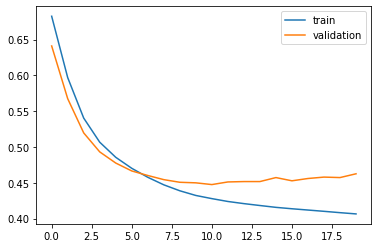

Accuracy


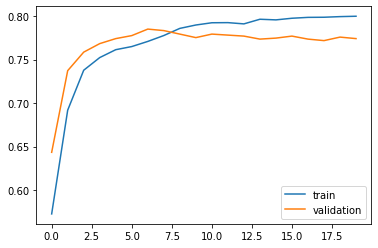

In [ ]:
# plot training history
print("loss")
plt.plot(training_phase.history["loss"], label="train")
plt.plot(training_phase.history["val_loss"], label="validation")
plt.legend()
plt.show()
print("Accuracy")
plt.plot(training_phase.history["accuracy"], label="train")
plt.plot(training_phase.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

We see the the loss on the training set keeps getting lower as the epochs grow, but that's not the case for the validation: from about epoch 10, we notice that the model starts to go in a growing overfitting

In [ ]:
y_pred = nn_model.predict(nn_dataset)
# We will look at the predicted Qualities to ensure we have something sensible.
y_pred = np.round(y_pred).astype(bool)
print(y_pred)

[[False]
 [False]
 [False]
 ...
 [ True]
 [False]
 [ True]]


In [ ]:
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

[[3388  927]
 [ 852 3526]]
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.79      0.79      4315
        True       0.79      0.81      0.80      4378

    accuracy                           0.80      8693
   macro avg       0.80      0.80      0.80      8693
weighted avg       0.80      0.80      0.80      8693



In [ ]:
# generate a submission file
generateSubmission(
    model=nn_model,
    model_preprocessor=nn_preprocessor,
    model_postprocessor = FunctionTransformer(lambda y: np.round(y).astype(bool)),
    file_name="nn_basic.csv",
    direct_submit_to_kaggle=False
)

     PassengerId  transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01        False
...          ...          ...
4272     9266_02         True
4273     9269_01         True
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


### K-Fold cross validation

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scikeras.wrappers import KerasClassifier

keras_model_classifier = KerasClassifier(
    model=simple_nn_model,
    input_shape=nn_dataset.columns.size,
    hidden_units=(12, 6),
    hidden_activation="relu",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

Epoch 1/20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


145/145 [==============================] - 1s 4ms/step - loss: 0.7247 - accuracy: 0.5729 - auc_1: 0.6692 - val_loss: 0.6379 - val_accuracy: 0.6471 - val_auc_1: 0.7421
Epoch 2/20
145/145 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.7006 - auc_1: 0.7740 - val_loss: 0.5827 - val_accuracy: 0.7058 - val_auc_1: 0.7772
Epoch 3/20
145/145 [==============================] - 0s 2ms/step - loss: 0.5497 - accuracy: 0.7280 - auc_1: 0.8026 - val_loss: 0.5519 - val_accuracy: 0.7274 - val_auc_1: 0.7927
Epoch 4/20
145/145 [==============================] - 0s 2ms/step - loss: 0.5244 - accuracy: 0.7403 - auc_1: 0.8195 - val_loss: 0.5333 - val_accuracy: 0.7463 - val_auc_1: 0.8045
Epoch 5/20
145/145 [==============================] - 0s 3ms/step - loss: 0.5073 - accuracy: 0.7478 - auc_1: 0.8305 - val_loss: 0.5202 - val_accuracy: 0.7506 - val_auc_1: 0.8145
Epoch 6/20
145/145 [==============================] - 0s 3ms/step - loss: 0.4944 - accuracy: 0.7565 - auc_1: 0.8398 - val

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Average score: 0.7579654321411162')

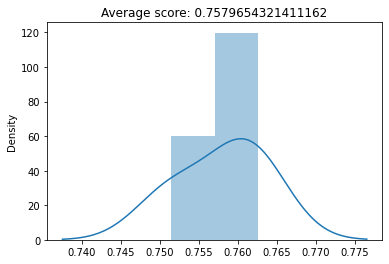

In [ ]:
SPLIT = 3
cv_scores = cross_val_score(
    keras_model_classifier, nn_dataset, target, cv=SPLIT, scoring="accuracy", verbose=1,
)
sns.distplot(cv_scores)
plt.title("Average score: {}".format(np.mean(cv_scores)))

### Grid Search Parameter Tuning

In [ ]:
# Create the parameter grids
parameter_grid = {
    "hidden_units": [(10,10),(20,20)], ## (40,40)],
    "hidden_activation": ["relu"], #], "tanh"],
    "epochs": [10, 20, 30],
    "batch_size": [1, 32], # 64],
    "verbose": [0],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=6)
cross_validation.get_n_splits(nn_dataset, target)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=keras_model_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=False,  # True,
    refit="accuracy",
)

# You can use X_train without manual preprocessing because preprocessor is built-in the classifier pipeline
grid_search.fit(nn_dataset, target)

Fitting 6 folds for each of 12 candidates, totalling 72 fits


In [ ]:
# grid_search.cv_results_

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_nn = grid_search.best_estimator_
best_nn

We ran a a very massive Grid Search for Neaural netowrks, for many hours of trainings, trying to explore and discover which where the best parameters. 
This model was the first to go beyond 0.8 score in the Kaggle competirion
```
Best score: 0.790518672304644
Best parameters: {'batch_size': 1, 'epochs': 30, 'hidden_activation': 'relu', 'hidden_units': (40, 40), 'verbose': 0}
KerasClassifier(
	model=<function simple_nn_model at 0x7fb6d58c80e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=1
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=30
	input_shape=13
	hidden_units=(40, 40)
	hidden_activation=relu
	class_weight=None
)
```



In [ ]:
best_nn = KerasClassifier(
    model=simple_nn_model,
    input_shape=nn_dataset.columns.size,
    build_fn=None,
    warm_start=False,
    random_state=None,
    optimizer="rmsprop",
    loss=None,
    metrics=None,
    batch_size=1,
    validation_batch_size=None,
    verbose=0,
    callbacks=None,
    validation_split=0.2,
    shuffle=True,
    run_eagerly=False,
    epochs=30,
    hidden_units=(40, 40),
    hidden_activation="relu",
    class_weight=None
)
best_nn.fit(nn_dataset,target);

In [ ]:
y_pred = best_nn.predict(nn_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3579  736]
 [ 716 3662]]
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.83      0.83      4315
        True       0.83      0.84      0.83      4378

    accuracy                           0.83      8693
   macro avg       0.83      0.83      0.83      8693
weighted avg       0.83      0.83      0.83      8693



### Submit the final model

In [ ]:
# generate a submission file
generateSubmission(
    model=best_nn,
    model_preprocessor = nn_preprocessor,
    model_postprocessor = FunctionTransformer(lambda y: np.round(y).astype(bool)),
    file_name="best_NN.csv",
    direct_submit_to_kaggle=True
)

     PassengerId  transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01         True
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]
Pushin submission to Kaggle...
Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 56.2k/56.2k [00:02<00:00, 22.3kB/s]
Successfully submitted to Spaceship Titanic

---
# SVM

## Preprocessing


In [ ]:
svm_dataset = pp_dataset.copy()

In [ ]:
# Create categorical transformer (binary + nominal)
categorical_transformer = Pipeline(
    steps=[
        ("one_hot_encoder", OneHotEncoder(sparse=False)),
        # ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
# Create numeric transformer
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [ ]:
# Create the transformer of mixed type columns
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)


In [ ]:
# Fit the column transformer
numerizer.fit(svm_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer())
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.0s


In [ ]:
svm_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", dt_column_dropper),
          #  ("sorter", columns_sorter)
    ]
)

svm_dataset = svm_preprocessor.transform(svm_dataset)

## Training

In [ ]:
svmc = SVC(random_state=RANDOM_STATE)

C_values=[0.1, 1, 10]
# Create the parameter grids
parameter_grid = [{
    "C": C_values,
    "kernel": ["linear"],
}, 
{
    "C": C_values,
    "kernel": ["poly"],
    "degree": [2,3]
},
{
    "C": C_values,
    "kernel": ["rbf"],
    "gamma": [0.1,1,5]
}]

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=5)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=svmc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(svm_dataset, target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(random_state=3993),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'degree': [2, 3],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 5],
                          'kernel': ['rbf']}],
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
SVC(C=10, kernel='linear', random_state=3993)
```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_svmc = grid_search.best_estimator_
best_svmc

Best score: 0.789831993440935
Best parameters: {'C': 10, 'kernel': 'linear'}


SVC(C=10, kernel='linear', random_state=3993)

In [ ]:
y_pred = best_svmc.predict(svm_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3397  918]
 [ 868 3510]]
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.79      0.79      4315
        True       0.79      0.80      0.80      4378

    accuracy                           0.79      8693
   macro avg       0.79      0.79      0.79      8693
weighted avg       0.79      0.79      0.79      8693



---
# Ensemble Methods

## Preprocessing

In [ ]:
ens_dataset = pp_dataset.copy()

In [ ]:
# Create categorical transformer (binary + nominal)
categorical_transformer = Pipeline(
    steps=[
        ("one_hot_encoder", OneHotEncoder(sparse=False)),
        # ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
# Create numeric transformer
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [ ]:
# Create the transformer of mixed type columns
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)

In [ ]:
# Fit the column transformer
numerizer.fit(ens_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer())
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.0s


In [ ]:
ens_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", dt_column_dropper),
          #  ("sorter", columns_sorter)
    ]
)

ens_dataset = ens_preprocessor.transform(ens_dataset)

## Training

Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

votc = VotingClassifier(
    estimators=[('dt', best_dtc), ('svm', best_svmc )],
    voting='hard')
votc.fit(ens_dataset, target)

xtr, xte, ytr, yte = train_test_split(ens_dataset, target)

votc.fit(xtr, ytr)
votc.score(xte, yte)

Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=10), random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [50,100,200],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=bag_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)


Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                                         random_state=3993),
             param_grid={'n_estimators': [50, 100, 200]}, refit='accuracy',
             return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
BaggingClassifier(n_estimators=50, random_state=3993)
```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_bag = grid_search.best_estimator_
best_bag

Best score: 0.7800607118765129
Best parameters: {'n_estimators': 50}


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  n_estimators=50, random_state=3993)

In [ ]:
y_pred = best_bag.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3814  501]
 [ 551 3827]]
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.88      0.88      4315
        True       0.88      0.87      0.88      4378

    accuracy                           0.88      8693
   macro avg       0.88      0.88      0.88      8693
weighted avg       0.88      0.88      0.88      8693



Pasting Classifier

In [ ]:
pas_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=10), random_state=RANDOM_STATE, bootstrap=False, max_samples=2000)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [50,100,200],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=pas_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                                         bootstrap=False, max_samples=2000,
                                         random_state=3993),
             param_grid={'n_estimators': [50, 100, 200]}, refit='accuracy',
             return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
BaggingClassifier(n_estimators=100, random_state=3993)
```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_pas = grid_search.best_estimator_
best_pas

Best score: 0.7805207465312223
Best parameters: {'n_estimators': 100}


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  bootstrap=False, max_samples=2000, n_estimators=100,
                  random_state=3993)

In [ ]:
y_pred = best_pas.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3687  628]
 [ 662 3716]]
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.85      0.85      4315
        True       0.86      0.85      0.85      4378

    accuracy                           0.85      8693
   macro avg       0.85      0.85      0.85      8693
weighted avg       0.85      0.85      0.85      8693



Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [100,200,500],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2"]
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=rnd_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=3993),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
RandomForestClassifier(criterion='entropy', n_estimators=500, max_features="sqrt", random_state=3993)
```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_rnd = grid_search.best_estimator_
best_rnd

Best score: 0.790870864912768
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=500, random_state=3993)

In [ ]:
y_pred = best_rnd.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[4310    5]
 [   1 4377]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4315
        True       1.00      1.00      1.00      4378

    accuracy                           1.00      8693
   macro avg       1.00      1.00      1.00      8693
weighted avg       1.00      1.00      1.00      8693



Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [100,200,500, 700, 1000],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2"]
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=ext_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=ExtraTreesClassifier(random_state=3993),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 500, 700, 1000]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
ExtraTreesClassifier(criterion='entropy', max_features='sqrt', n_estimators=200, random_state=3993)
```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_ext = grid_search.best_estimator_
best_ext

Best score: 0.7882244090842956
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}


ExtraTreesClassifier(criterion='entropy', max_features='sqrt', n_estimators=200,
                     random_state=3993)

In [ ]:
y_pred = best_ext.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[4314    1]
 [   5 4373]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4315
        True       1.00      1.00      1.00      4378

    accuracy                           1.00      8693
   macro avg       1.00      1.00      1.00      8693
weighted avg       1.00      1.00      1.00      8693



Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [50,100,500],
    "learning_rate": [0.2, 0.5, 1],
    "algorithm": ["SAMME", "SAMME.R"]
    
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=ada_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=3993),
             param_grid={'algorithm': ['SAMME.R'],
                         'base_estimator__max_depth': [1, 5],
                         'learning_rate': [0.2, 0.5, 1],
                         'n_estimators': [50, 100]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=50, algorithm="SAMME.R", random_state=3993)

```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_ada = grid_search.best_estimator_
best_ada

Best score: 0.7936319987302092
Best parameters: {'algorithm': 'SAMME.R', 'base_estimator__max_depth': 1, 'learning_rate': 0.5, 'n_estimators': 50}


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, random_state=3993)

In [ ]:
y_pred = best_ext.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[4314    1]
 [   5 4373]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4315
        True       1.00      1.00      1.00      4378

    accuracy                           1.00      8693
   macro avg       1.00      1.00      1.00      8693
weighted avg       1.00      1.00      1.00      8693



XGBoost

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()

# Create the parameter grids
parameter_grid = {
    "eta": [0.01,0.1,0.3,0.5],
    "gamma": [0, 0.1, 1, 10],
    "max_depth": [1, 2, 4, 6, 8]
    
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=XGBClassifier(),
             param_grid={'eta': [0.01, 0.1, 0.3, 0.5], 'gamma': [0, 0.1, 1, 10],
                         'max_depth': [1, 2, 4, 6, 8]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
XGBClassifier(eta=0.01, gamma=10, max_depth=4)

```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_xgb = grid_search.best_estimator_
best_xgb

Best score: 0.797546922741161
Best parameters: {'eta': 0.01, 'gamma': 10, 'max_depth': 4}


XGBClassifier(eta=0.01, gamma=10, max_depth=4)

In [ ]:
y_pred = best_xgb.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3359  956]
 [ 627 3751]]
Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.78      0.81      4315
        True       0.80      0.86      0.83      4378

    accuracy                           0.82      8693
   macro avg       0.82      0.82      0.82      8693
weighted avg       0.82      0.82      0.82      8693



In [ ]:
generateSubmission(
    best_xgb,
    model_preprocessor = ens_preprocessor,
    file_name="xgboost.csv",
    direct_submit_to_kaggle=False    
)

     PassengerId  transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


Stacking ensemble

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

best_svmc = SVC(C=10, kernel='linear', random_state=RANDOM_STATE)
best_rnd = RandomForestClassifier(criterion='entropy', n_estimators=500, max_features="sqrt", random_state=RANDOM_STATE)
best_ext = ExtraTreesClassifier(criterion='entropy', max_features='sqrt', n_estimators=200, random_state=RANDOM_STATE)
best_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=50, algorithm="SAMME.R", random_state=RANDOM_STATE)
xgb_clf = xgb.XGBClassifier()
estimators = [best_rnd, best_ext, best_ada, best_svmc, best_xgb]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    ens_dataset, target, test_size=1000, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=1000, random_state=RANDOM_STATE)

for estimator in estimators:
  estimator.fit(X_train, y_train)

X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=RANDOM_STATE)
rnd_forest_blender.fit(X_val_predictions, y_val)

rnd_forest_blender.oob_score_


0.783

In [ ]:
from sklearn.metrics import accuracy_score

X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
y_pred = rnd_forest_blender.predict(X_test_predictions)

accuracy_score(y_test, y_pred)

0.81

---
# Auto Sklearn

## Imports

In [ ]:
# sometimes you have to run this cell twice on colab
# !apt-get install swig -y
# !pip install Cython numpy
# !pip install scikit-learn --upgrade
!pip install auto-sklearn --upgrade
!pip install dask distributed --upgrade
# !pip install pipelineprofiler

#restart runtime
import os
os.kill(os.getpid(), 9)

## Dataset Preprocessing (just using the same as NN)

In [ ]:
auto_preprocessor = nn_preprocessor
auto_dataset = nn_dataset

## Training

In [ ]:
from autosklearn.classification import AutoSklearnClassifier
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(auto_dataset, target, random_state=1)

automl = AutoSklearnClassifier(time_left_for_this_task=60*5) #Auto-sklearn searches pipelines for 5 minutes; use ensemble_size=1 for a single model

automl.fit(X_train, y_train)

y_hat = automl.predict(X_test)

print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.sprint_statistics())

In [ ]:
print(automl.leaderboard())

In [ ]:
automl.show_models()

In [ ]:
# import PipelineProfiler

# data = PipelineProfiler.import_autosklearn(automl)
# PipelineProfiler.plot_pipeline_matrix(data)

## Submission

In [ ]:
# generate a submission file
generateSubmission(
    model=automl,
    model_preprocessor = auto_preprocessor,
    model_postprocessor = FunctionTransformer(lambda y: np.round(y).astype(bool)),
    file_name="automl.csv",
    direct_submit_to_kaggle=False
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dataset[numeric_columns] =  MinMaxScaler().fit_transform(dataset[numeric_columns])